# Machine Learning Project: Water Quality Prediction

## Import Library

In [1]:
from collections import Counter
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

## Loading Dataset

In [2]:
water_quality_df = pd.read_csv('/kaggle/input/water-quality/water_potability.csv')
water_quality_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## Exploratory Data Analysis (EDA)

### Melihat informasi dataset

In [3]:
water_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


### Melihat deskripsi statistik pada fitur numerik

In [4]:
water_quality_df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


### Mengecek missing value pada dataset

In [5]:
water_quality_df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

### Mengecek nilai duplikasi pada dataset

In [6]:
print('Jumlah data duplikat: ', water_quality_df.duplicated().sum())

Jumlah data duplikat:  0


### Melihat korelasi antar fitur

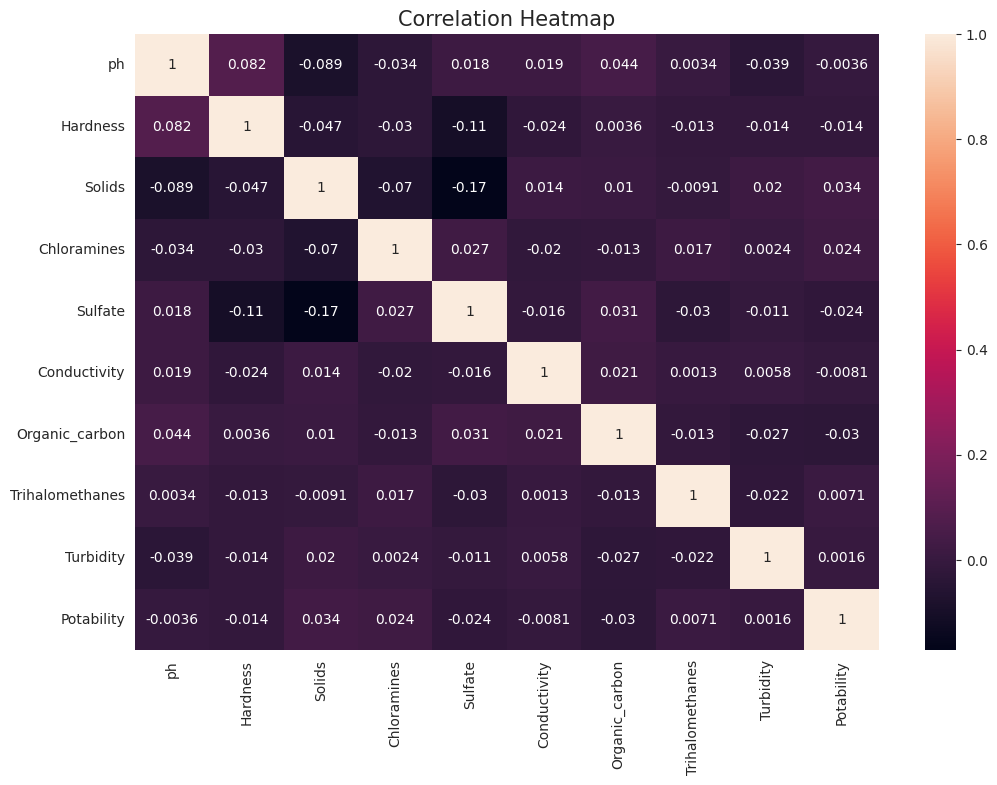

In [7]:
plt.figure(figsize=(12, 8))
sns.heatmap(
    data=water_quality_df.corr(),
    annot=True,
)
plt.title('Correlation Heatmap', fontsize=15)
plt.show()

### Melihat distribusi data pada tiap fitur

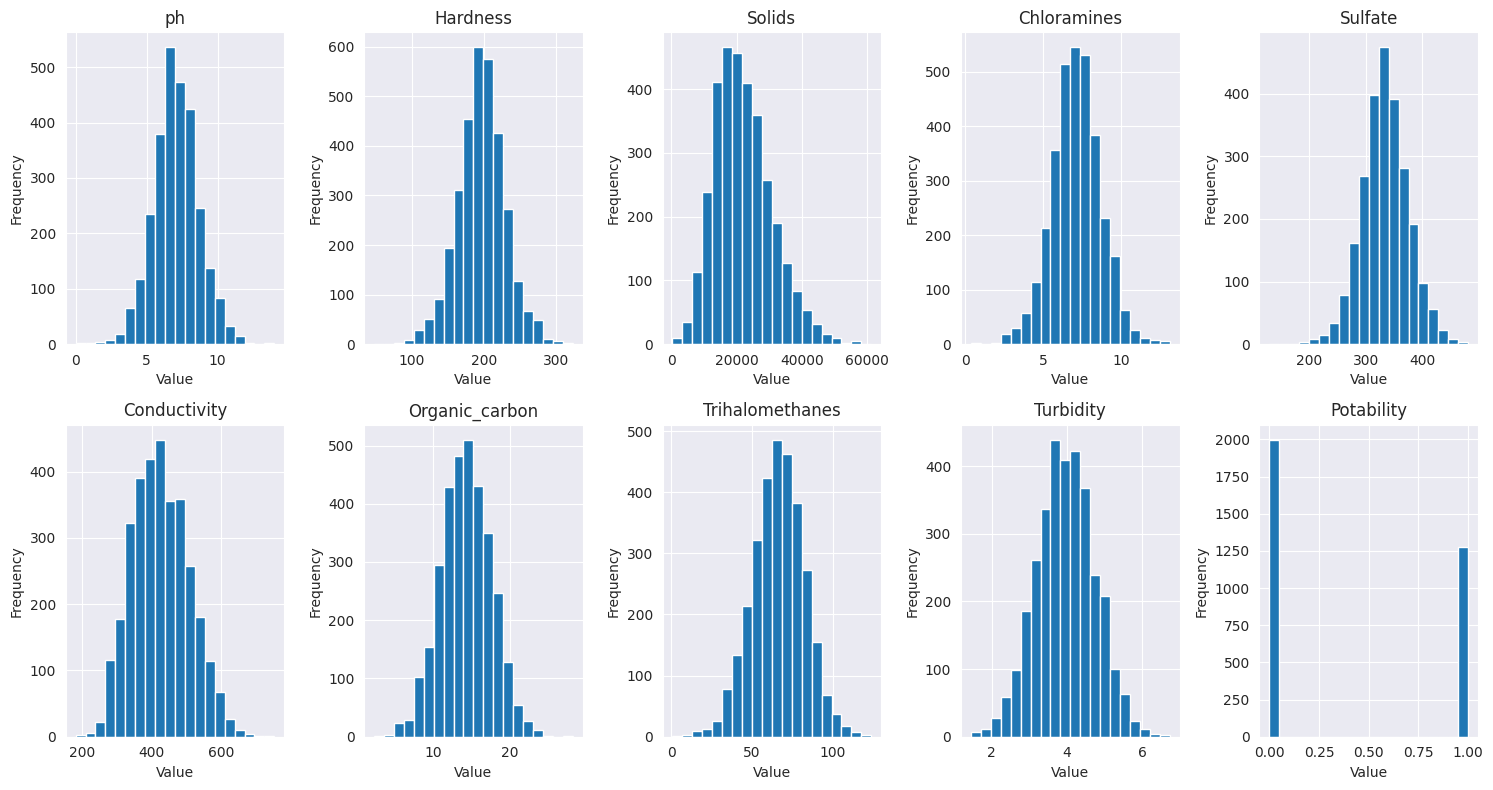

In [8]:
features = water_quality_df.columns

fig, axes = plt.subplots(2, 5, figsize=(15, 8))

axes = axes.flatten()

for index, col in enumerate(features):
    water_quality_df[col].hist(ax=axes[index], bins=20)
    axes[index].set_title(col)
    axes[index].set_xlabel('Value')
    axes[index].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Mengecek outlier

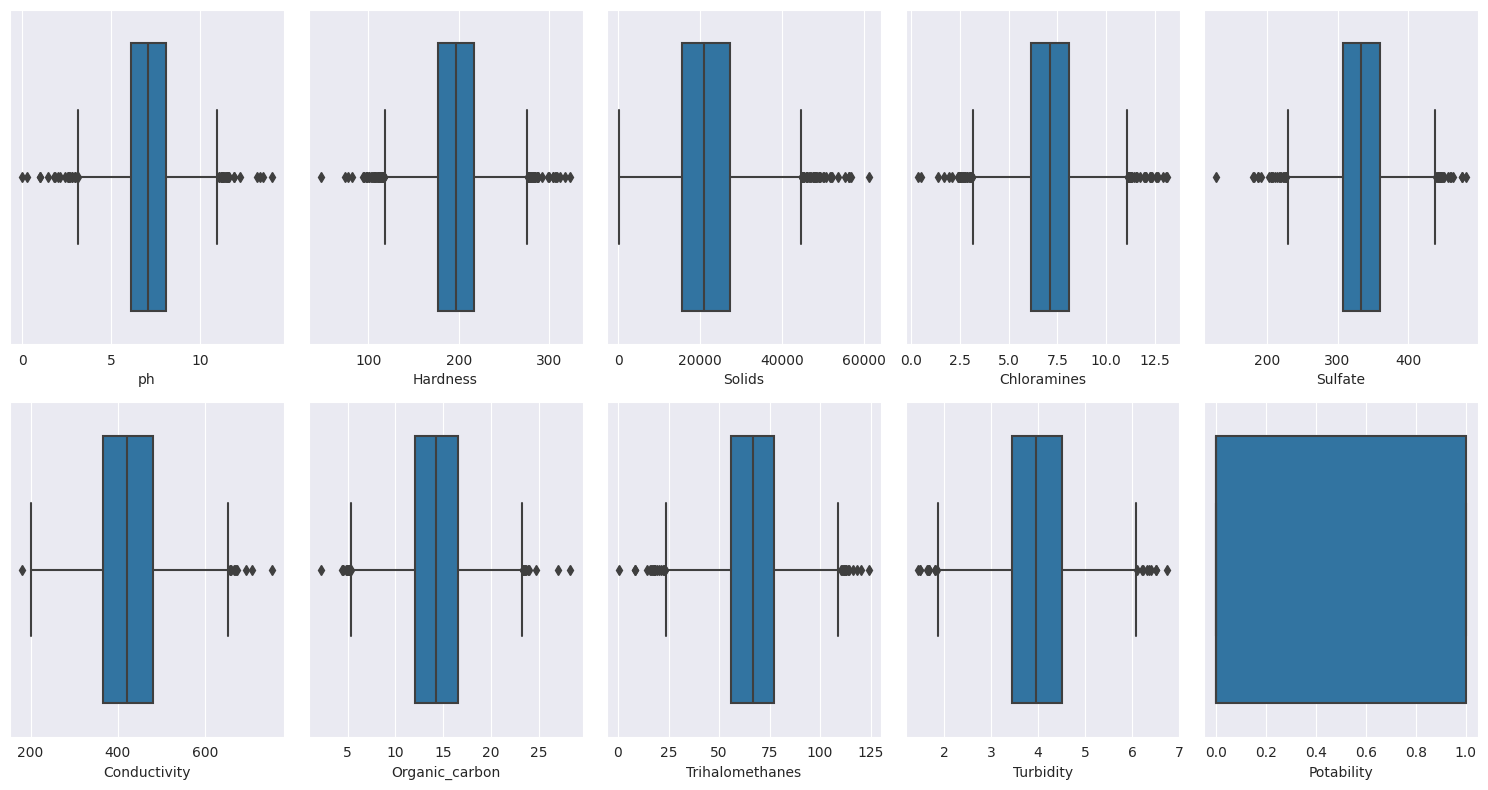

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(x=water_quality_df[col], ax=axes[i])

plt.tight_layout()
plt.show()

## Data Preparation

### Menghapus data pada missing value

In [10]:
water_quality_drop_df = water_quality_df.dropna()

In [11]:
water_quality_drop_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB


### Menangani outlier

In [12]:
numeric_features = water_quality_drop_df.drop(columns='Potability').columns


def get_min_max_outlier(columns):
    min_max = {}

    for col in columns:
        min_max[col] = water_quality_drop_df[col].mean() + 3 * water_quality_drop_df[col].std(), water_quality_drop_df[
            col].mean() - 3 * water_quality_drop_df[col].std()

    return min_max


min_max = get_min_max_outlier(numeric_features)

In [13]:
# Handling outlier with capping method
water_quality_clean_df = water_quality_drop_df.copy()

for value in min_max:
    water_quality_clean_df[value] = np.where(
        water_quality_clean_df[value] > min_max[value][0], min_max[value][0],
        np.where(
            water_quality_clean_df[value] < min_max[value][1], min_max[value][1], water_quality_clean_df[value]
        )
    )

water_quality_clean_df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
...,...,...,...,...,...,...,...,...,...,...
3267,8.989900,215.047358,15921.412018,6.297312,312.931022,390.410231,9.899115,55.069304,4.613843,1
3268,6.702547,207.321086,17246.920347,7.708117,304.510230,329.266002,16.217303,28.878601,3.442983,1
3269,11.491011,98.062818,37188.826022,9.263166,258.930600,439.893618,16.172755,41.558501,4.369264,1
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712,1


### Splitting dataset

In [14]:
X = water_quality_clean_df.drop(columns='Potability')
y = water_quality_clean_df['Potability']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
269,9.058628,155.357557,15737.468938,7.251979,343.233977,463.389256,17.854470,83.175189,3.652134
370,5.628407,226.830043,28334.491937,8.012497,293.924273,351.161213,15.019241,35.178662,5.050683
1233,5.214009,192.648846,34184.308402,5.783357,282.969879,380.428415,15.867751,80.498498,4.453526
3177,7.423586,180.453871,34451.984214,7.930651,303.790134,429.859999,7.665923,66.700476,3.365397
2042,7.669013,205.595635,11579.441693,4.263279,356.136518,407.721613,10.829045,83.243808,4.589513
...,...,...,...,...,...,...,...,...,...
2325,5.685216,154.570002,17628.043059,6.664444,390.094731,324.427772,17.352586,67.407300,4.066157
1087,7.156424,197.993538,27025.206963,6.734527,359.710517,448.457161,12.511973,49.299849,2.958415
465,5.445326,201.379459,28001.118179,7.208946,331.587484,365.091587,11.788777,65.944566,3.946990
821,5.226942,177.319603,28398.554196,6.294517,336.292918,328.387430,18.463095,62.075902,2.259550


### Melakukan scaling nilai

In [15]:
scaler = MinMaxScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns=X.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X.columns)

X_train_std

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,0.708966,0.292603,0.324400,0.512372,0.540486,0.560481,0.675278,0.673895,0.432168
1,0.345595,0.657611,0.589471,0.592351,0.341038,0.320187,0.533160,0.176329,0.730871
2,0.301697,0.483049,0.712565,0.357925,0.296729,0.382852,0.575692,0.646146,0.603330
3,0.535762,0.420769,0.718197,0.583744,0.380943,0.488691,0.164568,0.503106,0.370927
4,0.561761,0.549168,0.236905,0.198067,0.592674,0.441290,0.323122,0.674606,0.632374
...,...,...,...,...,...,...,...,...,...
1603,0.351613,0.288581,0.364182,0.450584,0.730028,0.262947,0.650121,0.510433,0.520595
1604,0.507461,0.510344,0.561920,0.457954,0.607130,0.528510,0.407481,0.322719,0.284003
1605,0.326201,0.527636,0.582456,0.507846,0.493378,0.350014,0.371230,0.495270,0.495143
1606,0.303067,0.404763,0.590819,0.411681,0.512410,0.271425,0.705786,0.455164,0.134739


### Melakukan oversampling dengan SMOTE

In [16]:
Counter(y_train)

Counter({1: 648, 0: 960})

In [17]:
smote = SMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_std, y_train)

print("Distirbusi kelas Potability setelah SMOTE: ", Counter(y_train_resampled))

Distirbusi kelas Potability setelah SMOTE:  Counter({1: 960, 0: 960})


## Modeling

In [18]:
rf = RandomForestClassifier(random_state=42).fit(X_train_resampled, y_train_resampled)
svm = SVC(random_state=42).fit(X_train_resampled, y_train_resampled)

print("Training model selesai!")

Training model selesai!


## Evaluating Model

In [19]:
y_pred = rf.predict(X_test_std)
cm = confusion_matrix(y_test, y_pred)

y_pred_2 = svm.predict(X_test_std)
cm2 = confusion_matrix(y_test, y_pred_2)

In [20]:
print("---Classification Report---")
print(classification_report(y_test, y_pred))

---Classification Report---
              precision    recall  f1-score   support

           0       0.73      0.76      0.75       240
           1       0.62      0.58      0.60       163

    accuracy                           0.69       403
   macro avg       0.68      0.67      0.67       403
weighted avg       0.69      0.69      0.69       403



In [21]:
print("---Classification Report---")
print(classification_report(y_test, y_pred_2))

---Classification Report---
              precision    recall  f1-score   support

           0       0.71      0.71      0.71       240
           1       0.58      0.58      0.58       163

    accuracy                           0.66       403
   macro avg       0.65      0.65      0.65       403
weighted avg       0.66      0.66      0.66       403



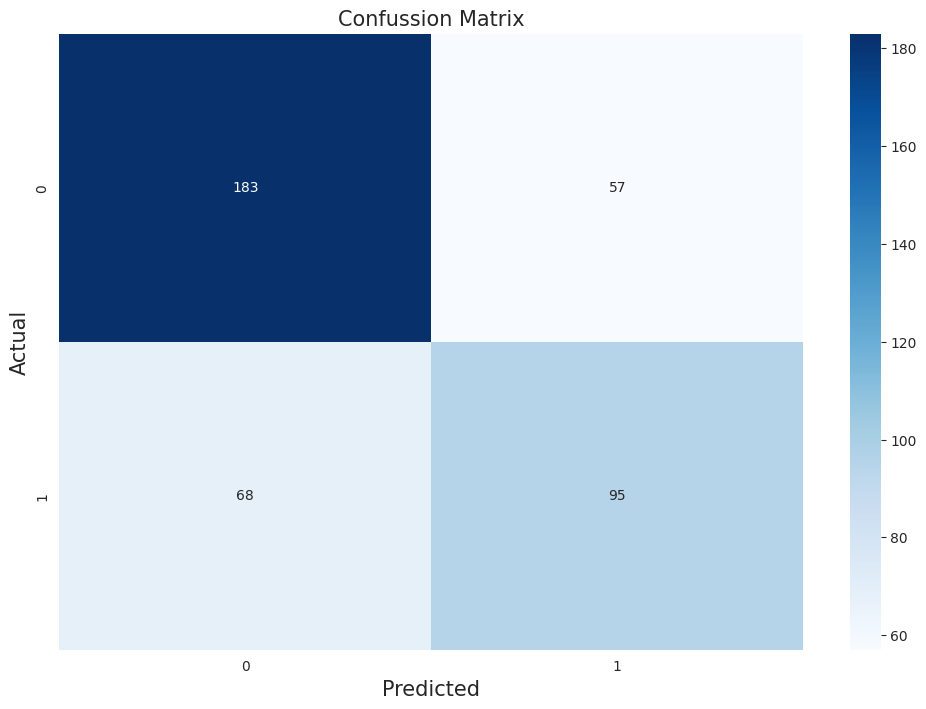

In [22]:
def plot_confusion_matrix(cm):
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted', fontsize=15)
    plt.ylabel('Actual', fontsize=15)
    plt.title('Confussion Matrix', fontsize=15)
    plt.show()

plot_confusion_matrix(cm)

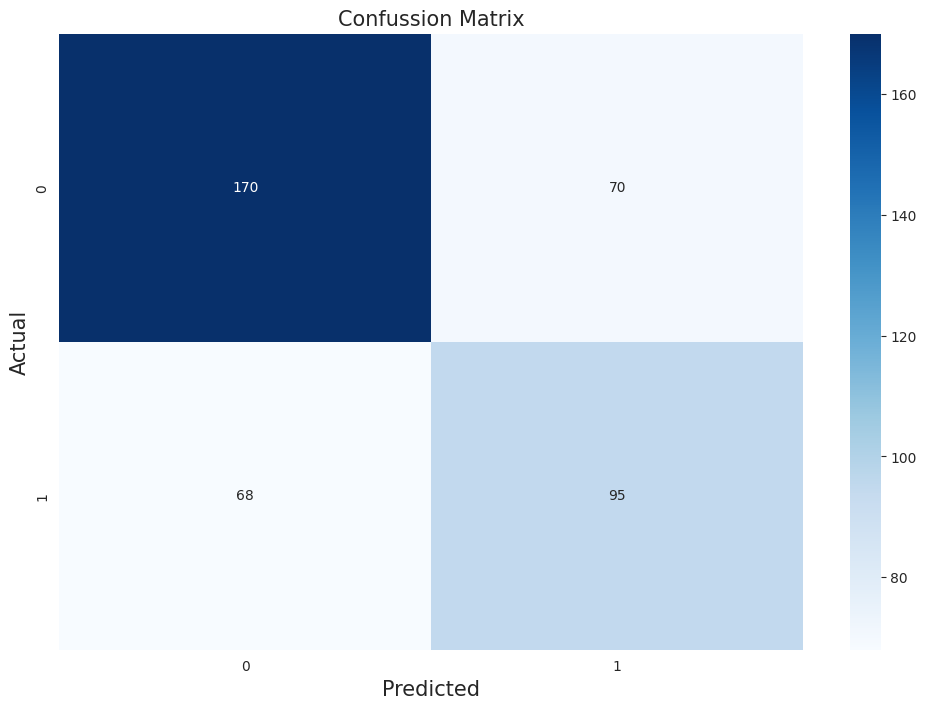

In [23]:
plot_confusion_matrix(cm2)

## Hyperparameter Tuning

In [24]:
param_rf_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
}

grid_search = GridSearchCV(rf, param_grid=param_rf_grid, cv=5, n_jobs=1, verbose=2)
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters for Random Forest Classifier: ", grid_search.best_params_)
best_grid = grid_search.best_estimator_

grid_search_score = best_grid.score(X_test_std, y_test)
print("Accuracy: ", grid_search_score)

n_estimators = grid_search.best_params_['n_estimators']
max_depth = grid_search.best_params_['max_depth']
min_samples_split = grid_search.best_params_['min_samples_split']
min_samples_leaf = grid_search.best_params_['min_samples_leaf']

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=1, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=1, min_samples_leaf

In [25]:
param_svm_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
}

grid_search_svm = GridSearchCV(svm, param_grid=param_svm_grid, cv=4, verbose=2)
grid_search_svm.fit(X_train_resampled, y_train_resampled)

print("Best parameters for SVM Classifier: ", grid_search_svm.best_params_)
best_grid_svm = grid_search_svm.best_estimator_

grid_search_svm_score = best_grid_svm.score(X_test_std, y_test)
print("Accuracy: ", grid_search_svm_score)

C = grid_search_svm.best_params_['C']
kernel = grid_search_svm.best_params_['kernel']

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   0.1s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.1s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.1s
[CV] END ...............................C=0.1, kernel=linear; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   0.1s
[CV] END .................................C=0.1, kernel=poly; total time=   0.2s
[CV] END .................................C=0.1, kernel=poly; total time=   0.1s
[CV] END .................................C=0.1, kernel=poly; total time=   0.1s
[CV] END .................................C=0.1, 

In [193]:
rf_tuning = RandomForestClassifier(
    random_state=42,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
).fit(X_train_resampled, y_train_resampled)

print("Training model selesai!")

Training model selesai!


In [26]:
rf_tuning = RandomForestClassifier(
    random_state=42,
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
).fit(X_train_resampled, y_train_resampled)

svm_tuning = SVC(
    random_state=42,
    C=C,
    kernel=kernel,
).fit(X_train_resampled, y_train_resampled)

print("Training model selesai!")

Training model selesai!


In [27]:
y_pred_tuning = rf_tuning.predict(X_test_std)
cm_tuning = confusion_matrix(y_test, y_pred_tuning)

y_pred_tuning2 = svm_tuning.predict(X_test_std)
cm_tuning2 = confusion_matrix(y_test, y_pred_tuning2)

In [28]:
plot_confusion_matrix(cm)

---Classification Report---
              precision    recall  f1-score   support

           0       0.68      0.65      0.67       240
           1       0.52      0.55      0.54       163

    accuracy                           0.61       403
   macro avg       0.60      0.60      0.60       403
weighted avg       0.62      0.61      0.61       403



In [29]:
print("---Classification Report---")
print(classification_report(y_test, y_pred_tuning2))

---Classification Report---
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       240
           1       0.56      0.58      0.57       163

    accuracy                           0.64       403
   macro avg       0.63      0.63      0.63       403
weighted avg       0.65      0.64      0.64       403



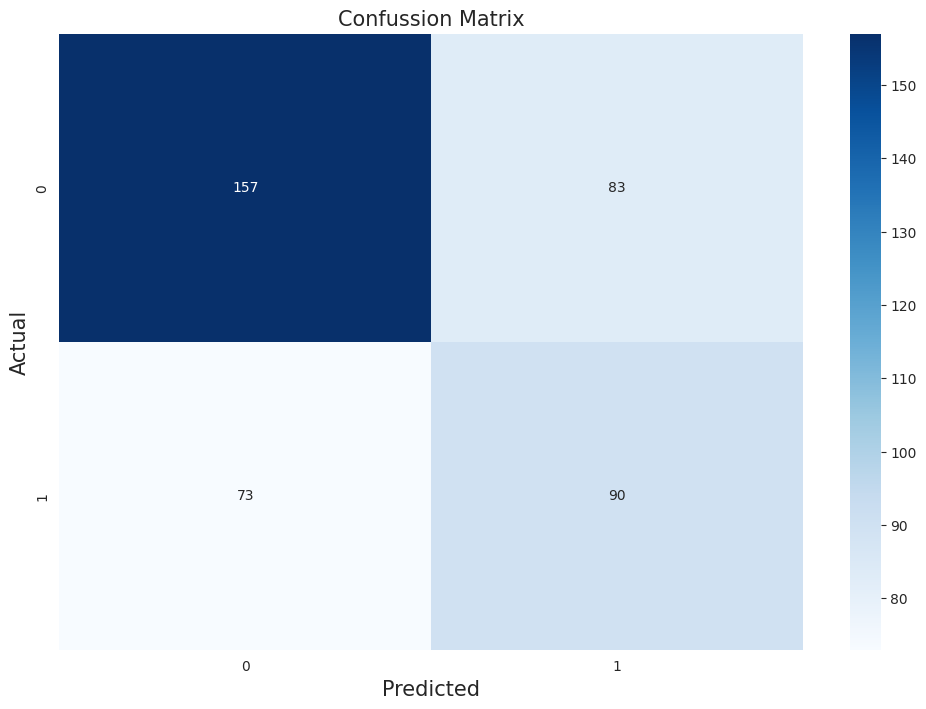

In [30]:
plot_confusion_matrix(cm_tuning)

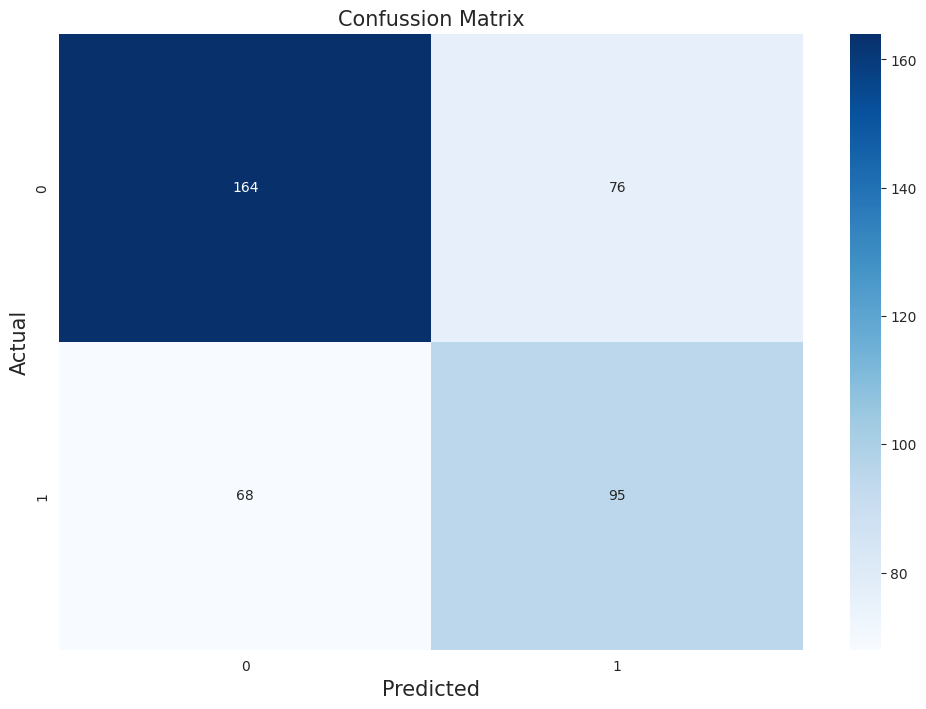

In [31]:
plot_confusion_matrix(cm_tuning2)